## Exploratory Data Analysis (EDA) Notebook
This notebook walks through the key steps of Exploratory Data Analysis (EDA) for the historical IFS dataset. Each step includes a short explanation and can be run directly on the training data.

**Data path:** `data/processed/historical_merged/historical_IFS_merged_201702_to_202504.csv`

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils.find_root import find_project_root

# Retrieve the project root dynamically
project_root = find_project_root()
os.chdir(project_root)

# Load dataset
DATASET_PATH = "data/processed/historical_merged/historical_IFS_merged_201702_to_202504.csv"
df = pd.read_csv(DATASET_PATH, parse_dates=['date'], index_col='date')
df = df.asfreq('h')
df.head()

,temperature_2m,surface_pressure,precipitation,wind_speed_10m
date,,,,
2017-02-01 00:00:00,9.6,1008.2,0.0,14.6
2017-02-01 01:00:00,9.6,1007.4,0.0,14.6
2017-02-01 02:00:00,9.9,1006.8,0.6,15.1
2017-02-01 03:00:00,10.0,1006.5,0.3,15.0
2017-02-01 04:00:00,10.2,1006.2,0.3,15.5


## Step 1: Dataset Overview
Check basic structure, number of rows, columns, data types, and missing values.

In [2]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72264 entries, 2017-02-01 00:00:00 to 2025-04-30 23:00:00
Freq: h
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature_2m    72264 non-null  float64
 1   surface_pressure  72264 non-null  float64
 2   precipitation     72264 non-null  float64
 3   wind_speed_10m    72264 non-null  float64
dtypes: float64(4)
memory usage: 2.8 MB


temperature_2m      0
surface_pressure    0
precipitation       0
wind_speed_10m      0
dtype: int64

**INSIGHTS**: No missing values, correct data types

## Step 2: Timestamp Continuity
Ensure that the datetime index has no missing or duplicate entries.

In [3]:
expected_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
missing_times = expected_range.difference(df.index)
print(f'Number of duplicate timestamps: {df.index.duplicated().sum()}')
print(f'Missing timestamps: {len(missing_times)}')

Number of duplicate timestamps: 0
Missing timestamps: 0


**INSIGHTS**: no gaps or duplicates in timestamps

## Step 3: Feature Distributions
Visualise how each variable is distributed.

In [4]:
from scipy.stats import skew

for col in ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']:
    col_skew = skew(df[col])
    print(f'{col}: skew = {col_skew:.2f}')


temperature_2m: skew = 0.19
surface_pressure: skew = -0.53
precipitation: skew = 7.93
wind_speed_10m: skew = 0.82


**INSIGHTS:**
The skewness analysis reveals that:

- **Temperature** (skew = 0.19) and **surface pressure** (skew = −0.53) are approximately symmetric and require no transformation.
- **Wind speed** (skew = 0.82) is moderately right-skewed; smoothing or robust scaling (e.g. IQR) is advisable.
- **Precipitation** (skew = 7.93) is highly right-skewed with most values near zero. Log (`log1p`) or Yeo-Johnson transformation are more appropriate than standard deviation-based methods.

These findings support the use of **robust scaling and non-parametric baselines** for skewed features, especially when preparing inputs for Isolation Forest or sequence-based models.

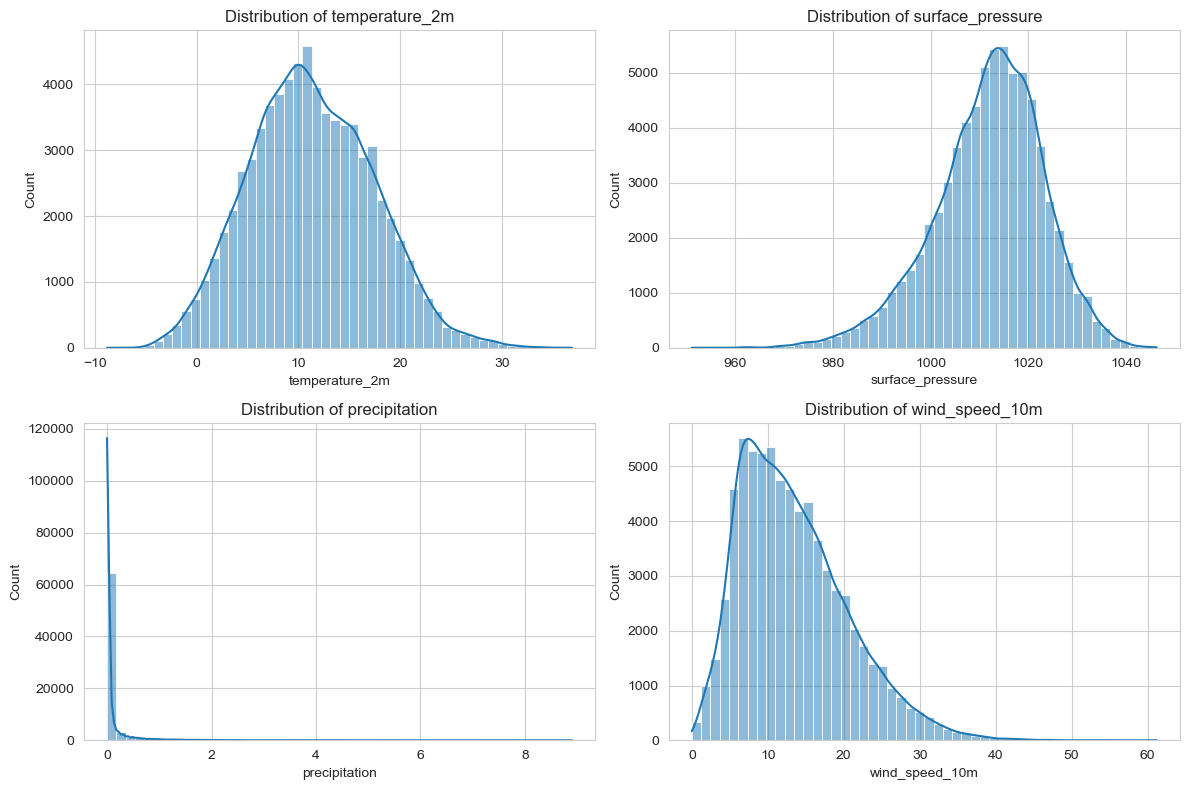

In [5]:
# Create a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Adjust size if needed

# Flatten the axes array to easily index it
axes = axes.flatten()

# Plot each column in its respective subplot
for i, col in enumerate(df.columns[:4]):  # Limit to 4 columns
    sns.histplot(df[col], kde=True, bins=50, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Step 4: Seasonal and Temporal Trends
Check for **monthly or seasonal patterns** over time.

In [6]:
#add time features
df['month'] = df.index.month
df['year'] = df.index.year
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek # Monday = 0, Sunday = 6
monthly_features = ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']

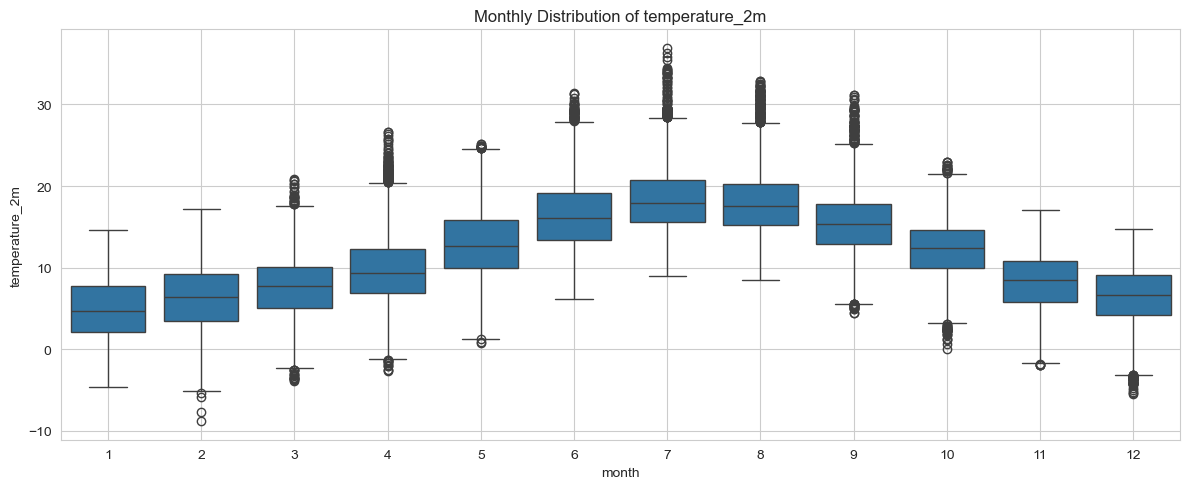

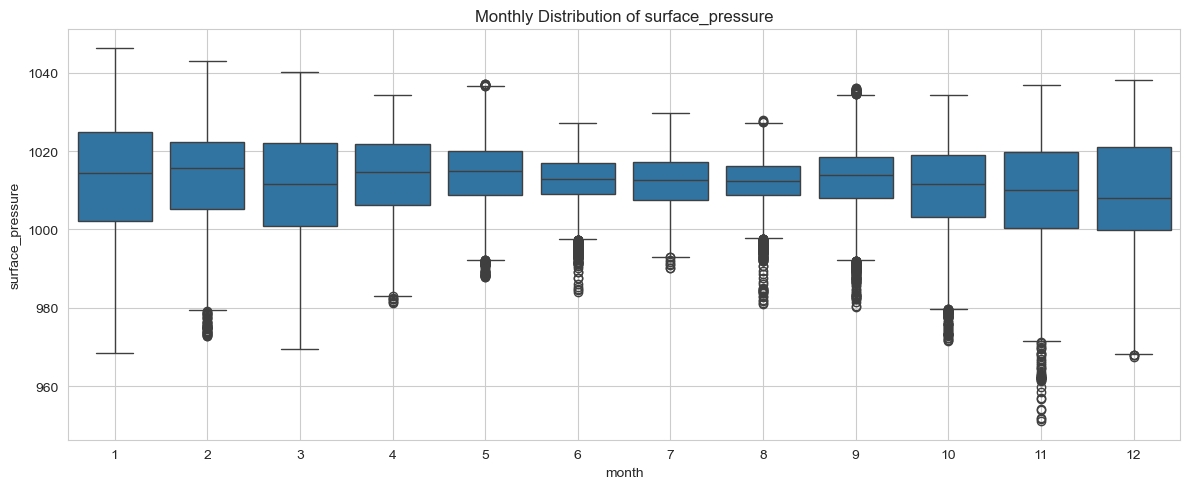

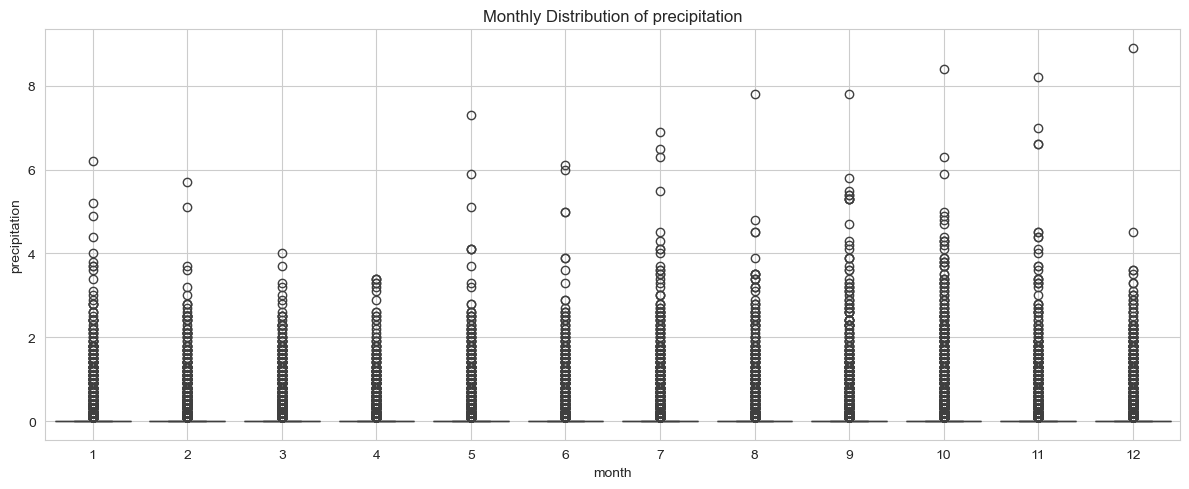

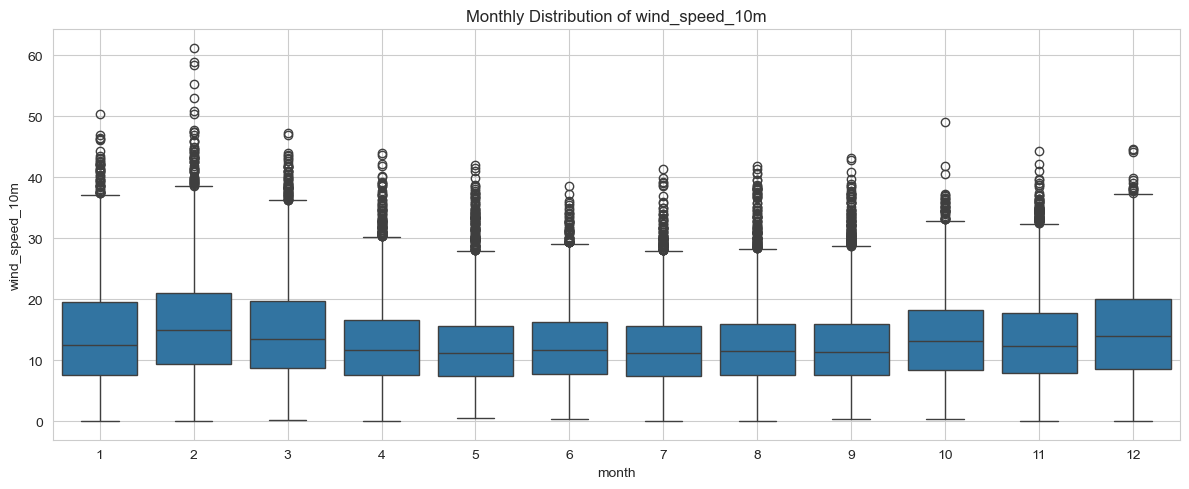

In [7]:
# Monthly box plot (for seasonality)
for col in monthly_features:
    plt.figure(figsize=(12, 5))
    sns.boxplot(data=df, x='month', y=col)
    plt.title(f'Monthly Distribution of {col}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**INSIGHTS: Monthly Trends** – Key Modelling Insights

- **Temperature**: Strong seasonal pattern → use `month` or cyclical `hour_sin/cos` features.
- **Surface Pressure**: Subtle seasonality with winter variability → effective for detecting low-pressure anomalies.
- **Precipitation**: Highly sparse and right-skewed → apply `log1p()` or Yeo-Johnson transformation. IQR banding needs testing.
- **Wind Speed**: Moderate seasonal shift with occasional spikes → rolling IQR or smoothing recommended for anomaly detection.

Seasonal and time-of-day features should be explicitly encoded. Experiment with IQR baselining for skewed variables like precipitation and wind.

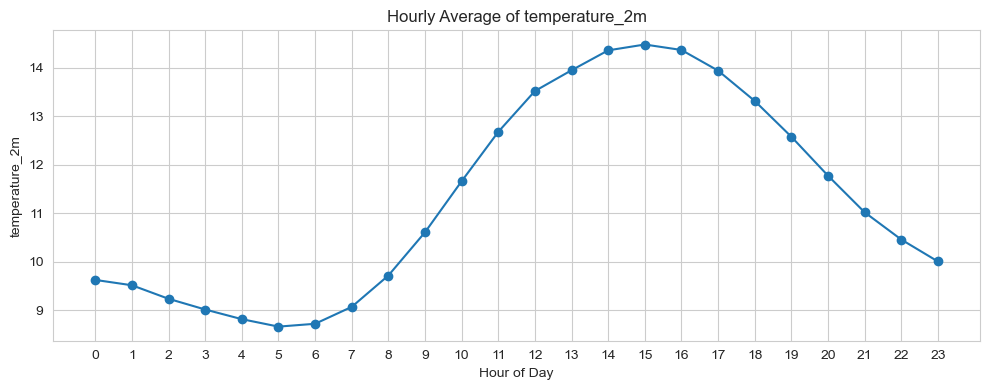

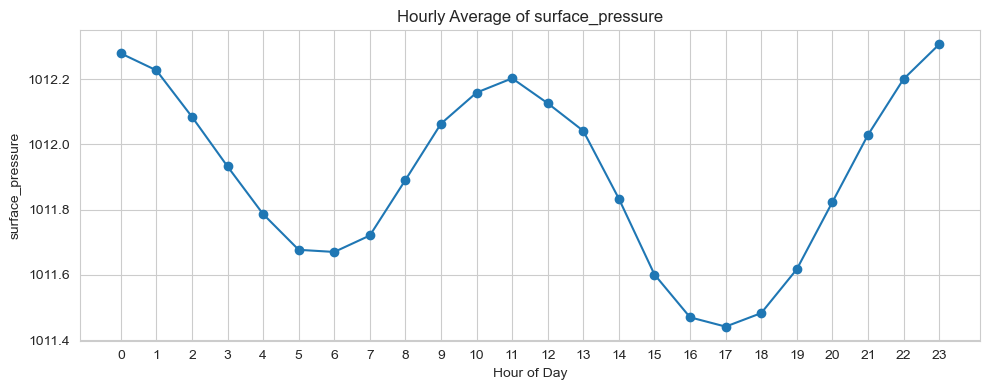

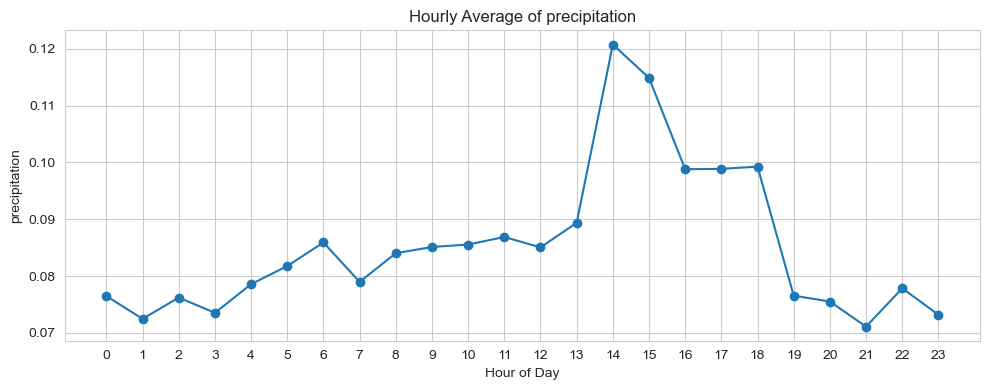

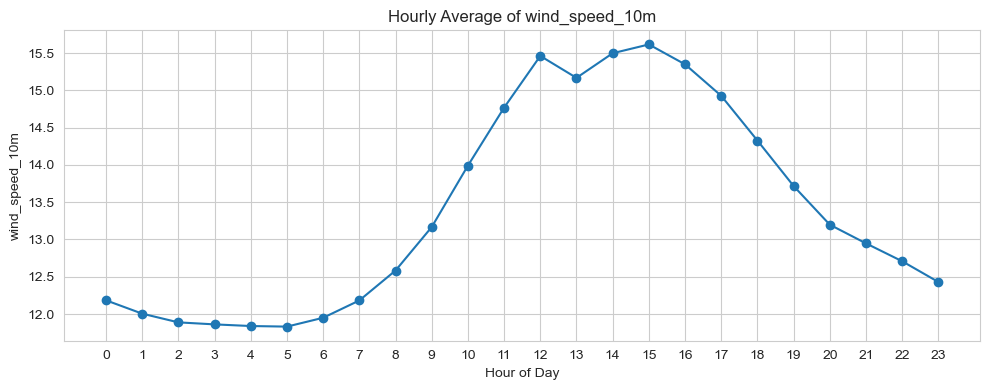

In [8]:
# Plot average value by hour for each variable for diurnal trends
for col in monthly_features:
    hourly_avg = df.groupby('hour')[col].mean()
    plt.figure(figsize=(10, 4))
    hourly_avg.plot(marker='o')
    plt.title(f'Hourly Average of {col}')
    plt.xlabel('Hour of Day')
    plt.ylabel(col)
    plt.xticks(ticks=range(24), labels=[str(h) for h in range(24)])  # Force all 24 ticks
    plt.grid(True)
    plt.tight_layout()
    plt.show()

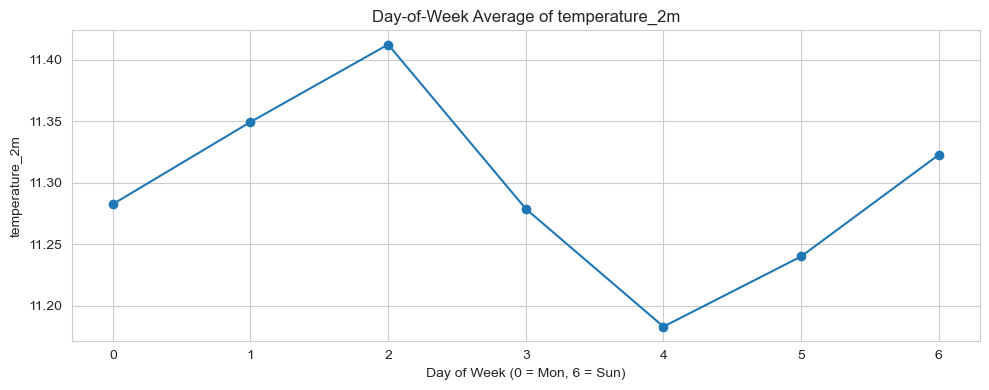

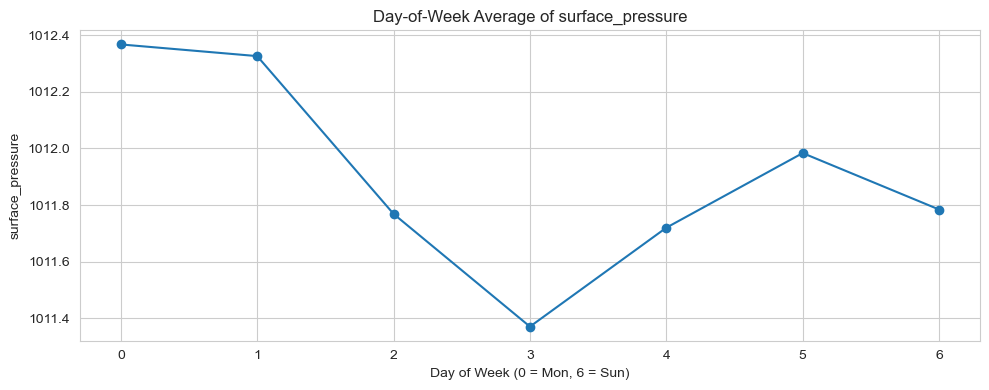

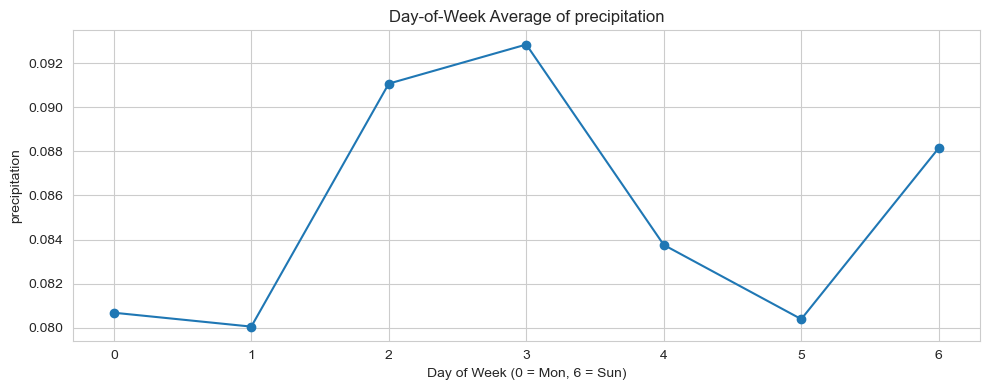

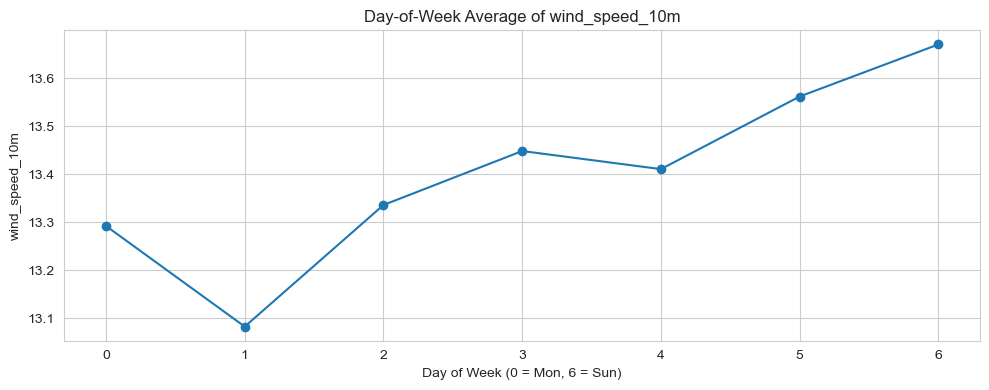

In [9]:
# Day of week patterns
for col in monthly_features:
    dow_avg = df.groupby('dayofweek')[col].mean()
    plt.figure(figsize=(10, 4))
    dow_avg.plot(marker='o')
    plt.title(f'Day-of-Week Average of {col}')
    plt.xlabel('Day of Week (0 = Mon, 6 = Sun)')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**INSIGHTS:**

**Hourly Trends**
- Temperature and wind speed show clear daily cycles, with highest values in the afternoon and lowest around 05:00.
- Surface pressure shows minimal variation across the day.
- Precipitation remains mostly flat but slightly higher in the late afternoon.

**Day-of-Week Trends**
- No meaningful differences are observed for temperature, pressure, or precipitation across the week.
- Wind speed is slightly higher at weekends, but the difference is small.

**Conclusion**
Hourly patterns are useful for feature engineering (e.g. `hour_sin`, `hour_cos`).


## Step 5: Feature Correlation
Use a heatmap to show how features relate to each other.

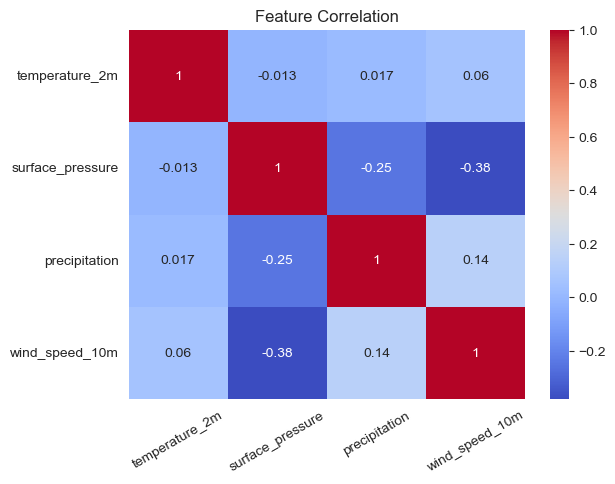

In [10]:
# Compute correlation matrix
corr = df.drop(columns=['month', 'year', 'dayofweek', 'hour']).corr()
# Create heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
# Set title
plt.title('Feature Correlation')
# Rotate x-axis labels
plt.xticks(rotation=30)
# Show plot
plt.show()

**INSIGHTS**: Feature Correlation Summary

This correlation heatmap shows how the four weather features are related to each other:

- **Temperature** has almost no correlation with wind speed, precipitation, or pressure.
- **Surface pressure** has a moderate negative correlation with wind speed (−0.38), and a weaker negative link with precipitation (−0.25), supported by established meteorological heuristics.
- **Precipitation** and **wind speed** are only very weakly correlated (+0.14).
- All values are below ±0.4, so there is no strong relationship between any of the features.

**Conclusion**: Each feature adds separate information. This is helpful for anomaly detection, as the models can treat them independently. It also improves explanation clarity when using SHAP or surrogate models.


## Step 6: Rolling Statistics Preview
Compute 60-day rolling mean and standard deviation for visual inspection.

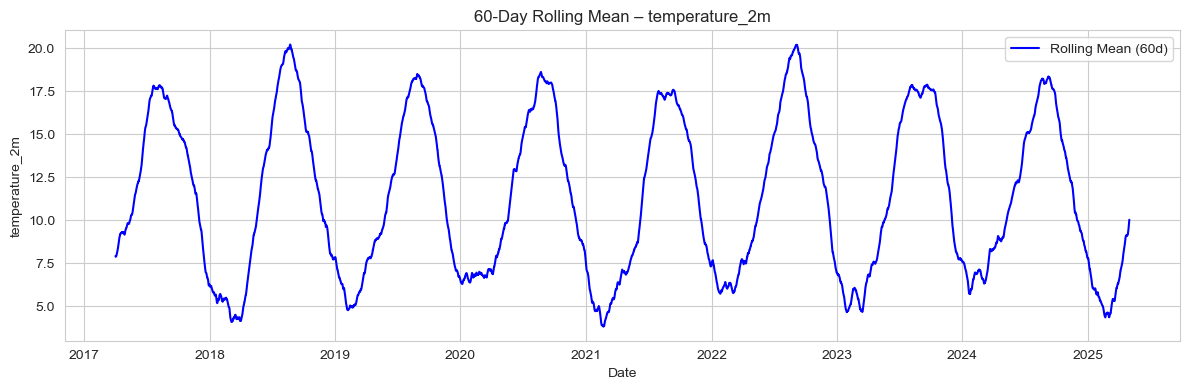

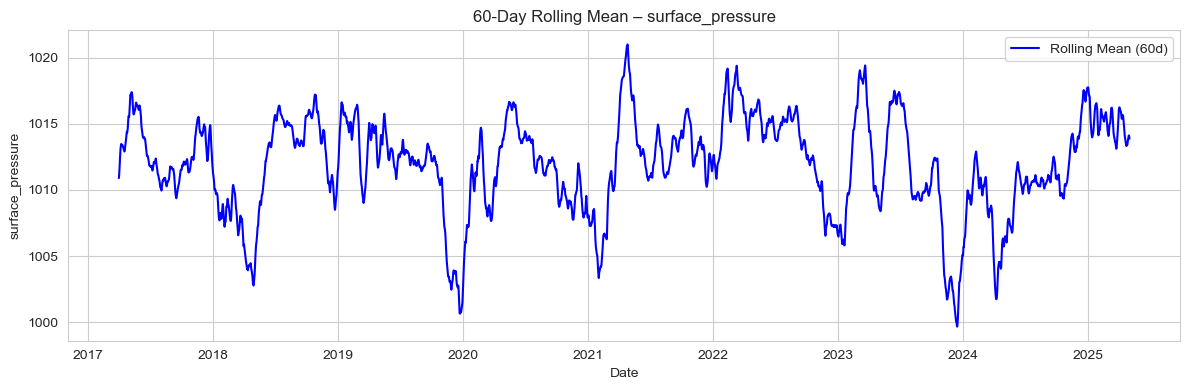

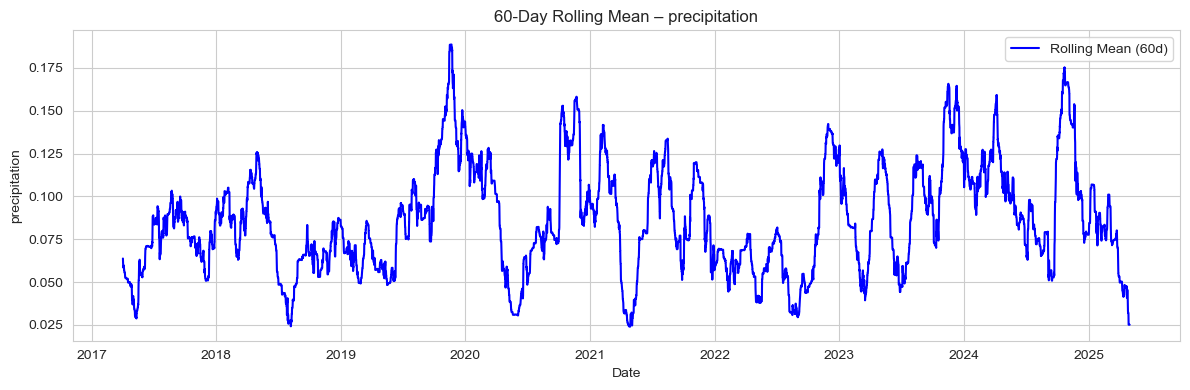

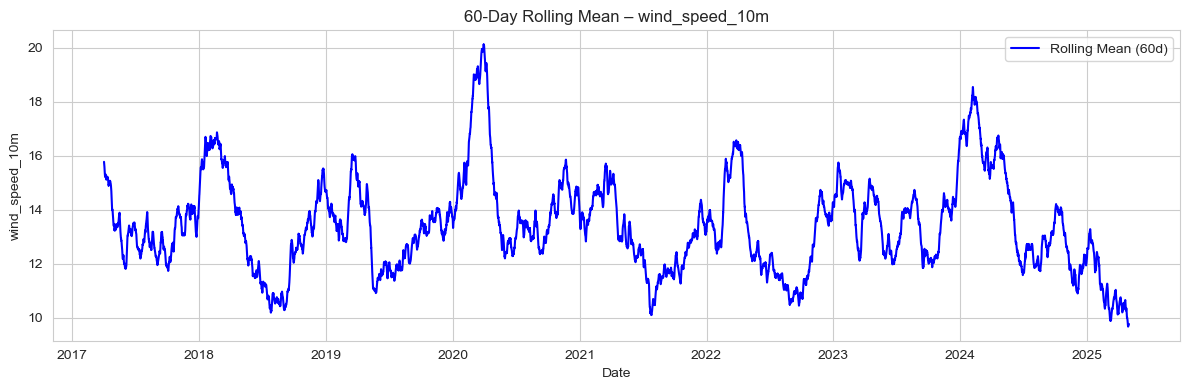

In [11]:
rolling_window = 1440  # 60 days

for col in ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']:
    rolling_mean = df[col].rolling(window=rolling_window).mean()

    plt.figure(figsize=(12, 4))
    plt.plot(df.index, rolling_mean, label='Rolling Mean (60d)', color='blue')
    plt.title(f'60-Day Rolling Mean – {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

**INSIGHTS:** 60-Day Rolling Mean – Key Insights

- **Temperature**: Stable seasonal pattern, ideal for baseline modelling.
- **Pressure**: Flat trend, suitable for fixed or relative thresholds.
- **Precipitation**: Too sparse for rolling mean and IQR.
- **Wind Speed**: Seasonal shape with occasional peaks; use IQR or smoothing.


## Step 7 Rollings Statistics Preview (Mean & Std Dev based)
**Purpose**: Visualise what’s considered normal over time for each feature <br>
**Method**: Plot the actual values along with their 60-day (1440-hr) rolling mean and ±2 standard deviation band. <br>
*Note*: These bands help **visualise outlier coverage** (EDA baseline), not to be confused with **input normalisation**.

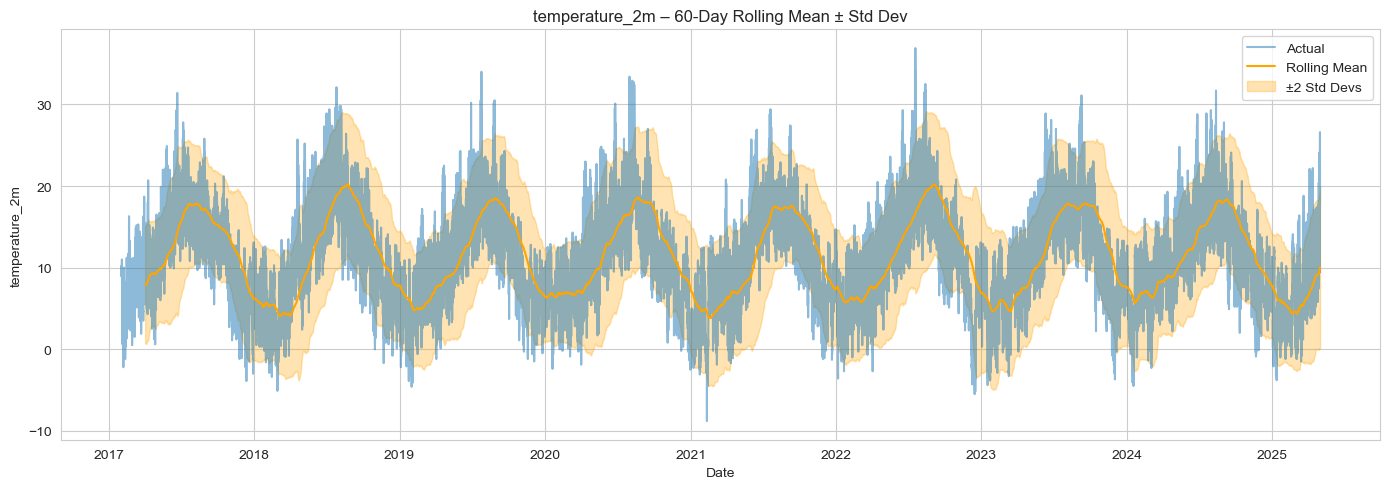

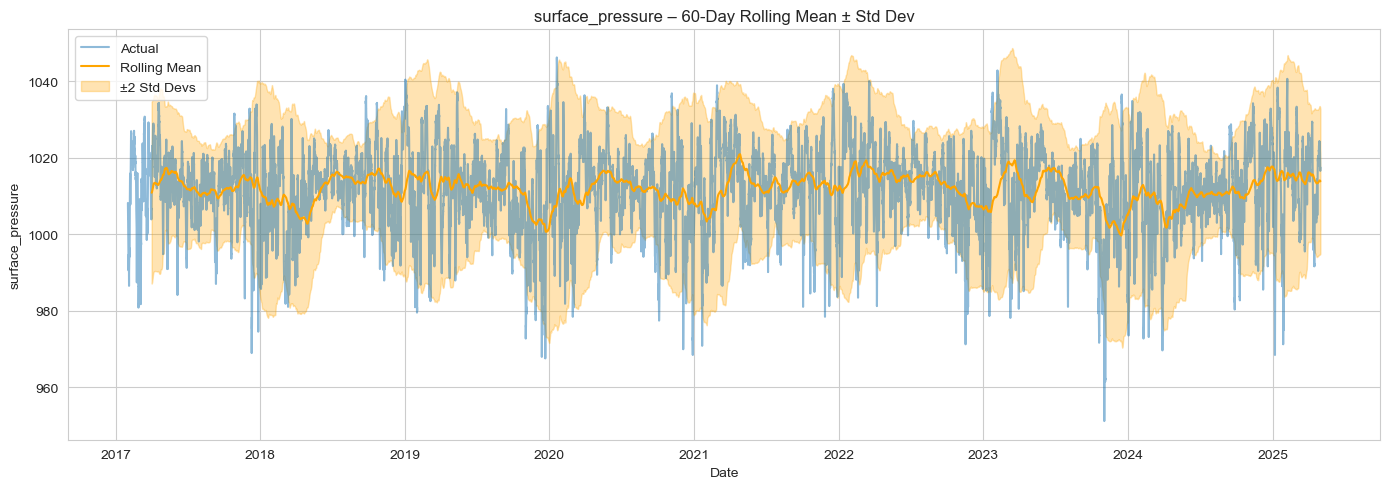

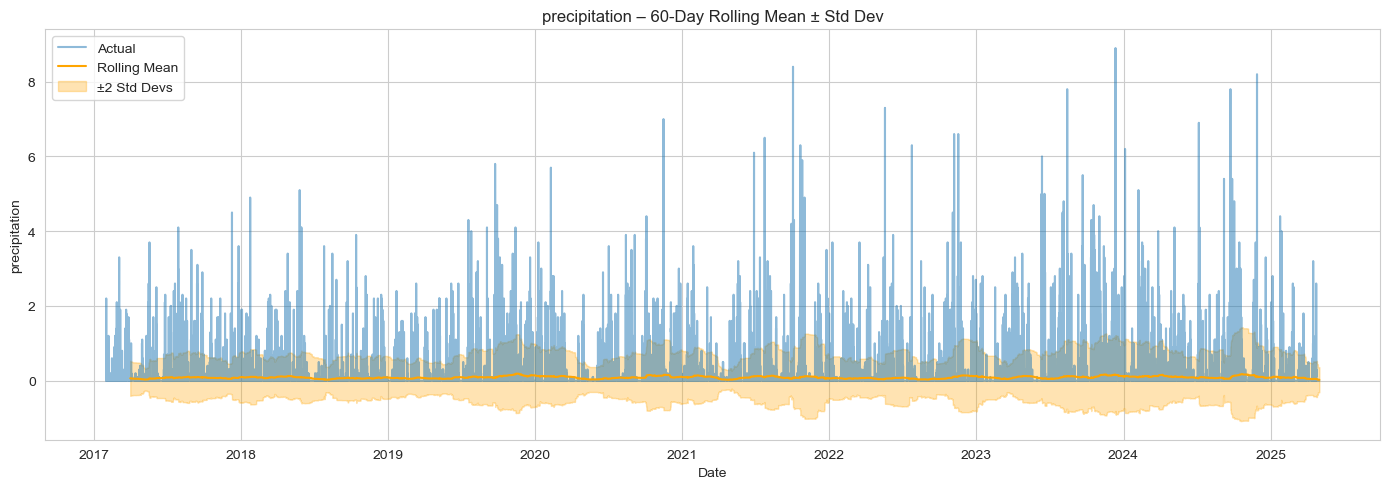

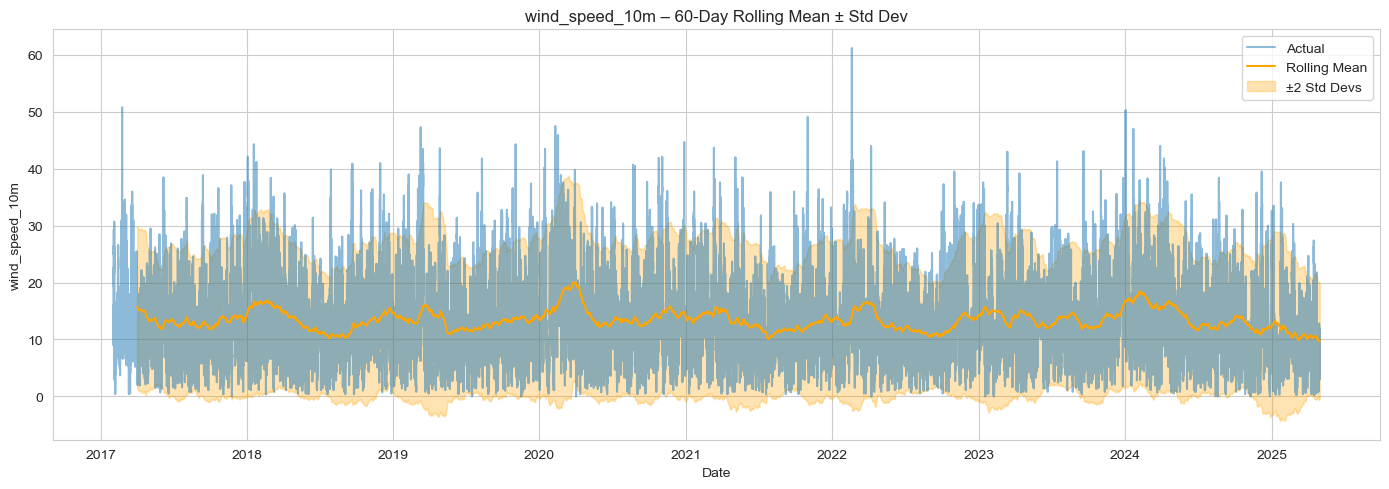

In [12]:
# Set rolling window: 60 days = 1440 hours
window = 1440

# Features to analyse
features = ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m']

# Plot rolling mean ± 1 std band for each feature
for col in features:
    rolling_mean = df[col].rolling(window=window).mean()
    rolling_std = df[col].rolling(window=window).std()

    plt.figure(figsize=(14, 5))
    plt.plot(df.index, df[col], label='Actual', alpha=0.5)
    plt.plot(df.index, rolling_mean, label='Rolling Mean', color='orange')
    plt.fill_between(
        df.index,
        rolling_mean - 2*rolling_std,
        rolling_mean + 2*rolling_std,
        color='orange',
        alpha=0.3,
        label='±2 Std Devs'
    )
    plt.title(f'{col} – 60-Day Rolling Mean ± Std Dev')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**INSIGHTS:** Rolling Mean ± 2 Std Dev – Key Insights

- **Temperature**: Stable and predictable. Std dev band fits well.
- **Pressure**: Flat and steady. A few dips may be useful as anomalies.
- **Precipitation**: The band is too narrow and detached from actual precipitation spikes, due to high sparsity and skew.
- **Wind Speed**: Std dev flags spikes, but overestimates variability during calm periods. IQR with smoothing may offer better balance.

**Conclusion**: Std dev works well for temperature and pressure, but not for precipitation. It is also less suitable for wind due to spike sensitivity.


## Step 8 Robust Rollings Statistics Preview (Median & IQR)
**Purpose**: Visualise what’s considered normal over time for each feature. <br>
**Method**: Plot the actual values along with their 60-day rolling median and ±1.5 IQR band (using a 1440-hour window). <br>
*Note*: These bands help **visualise outlier coverage** (EDA baseline), not to be confused with **input normalisation**.

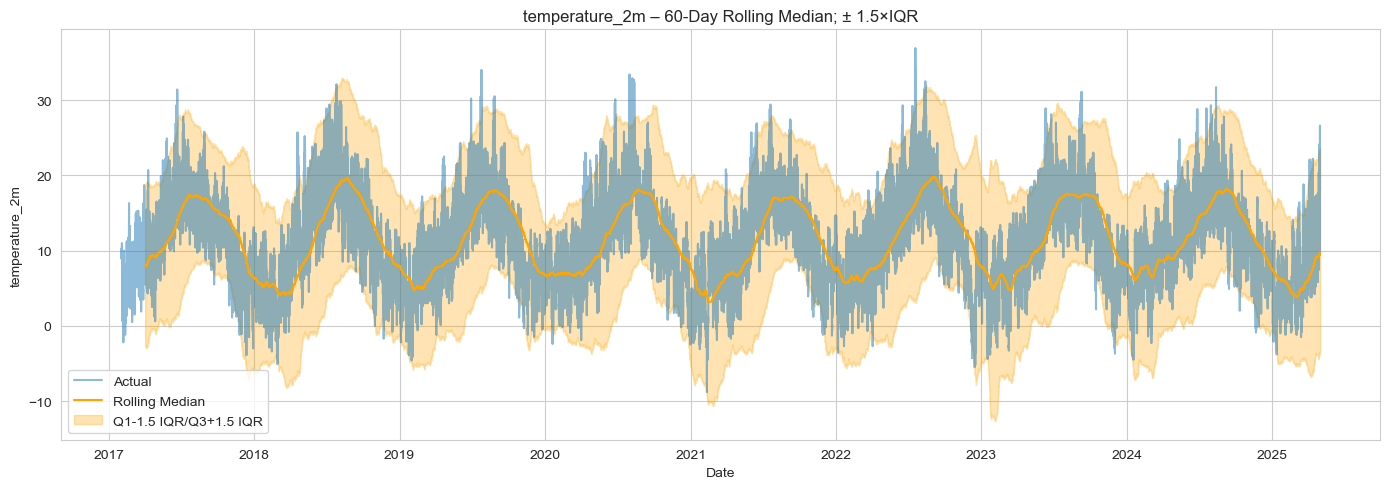

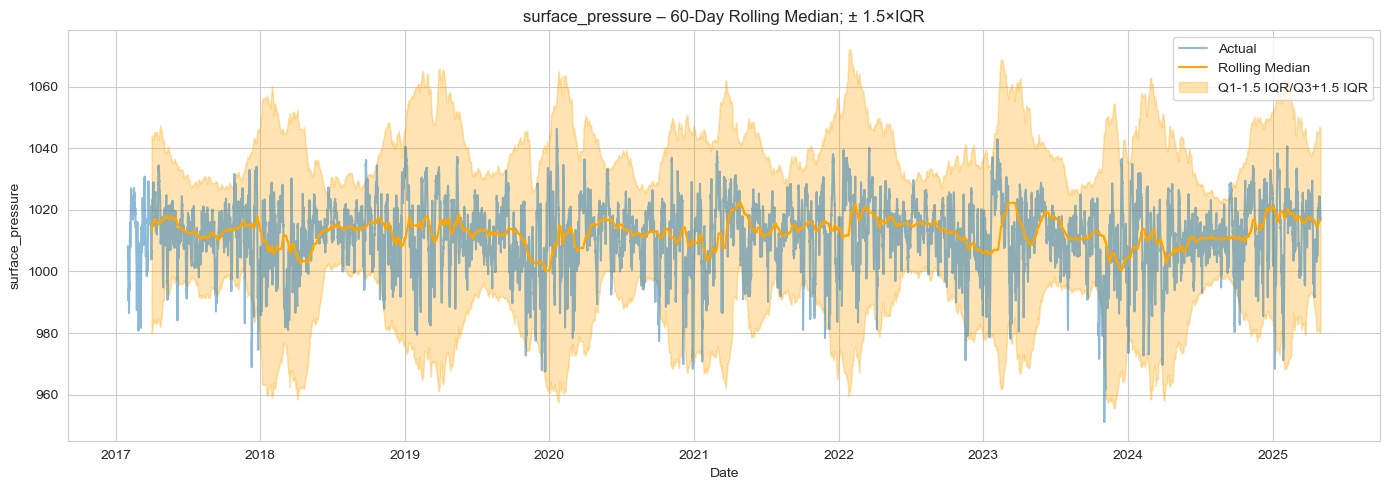

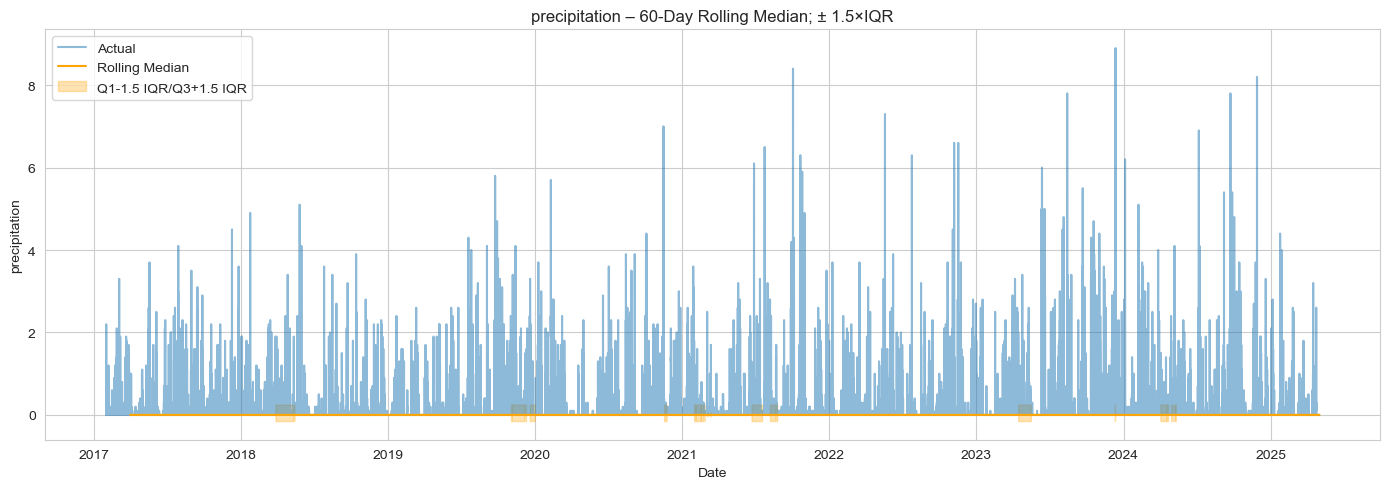

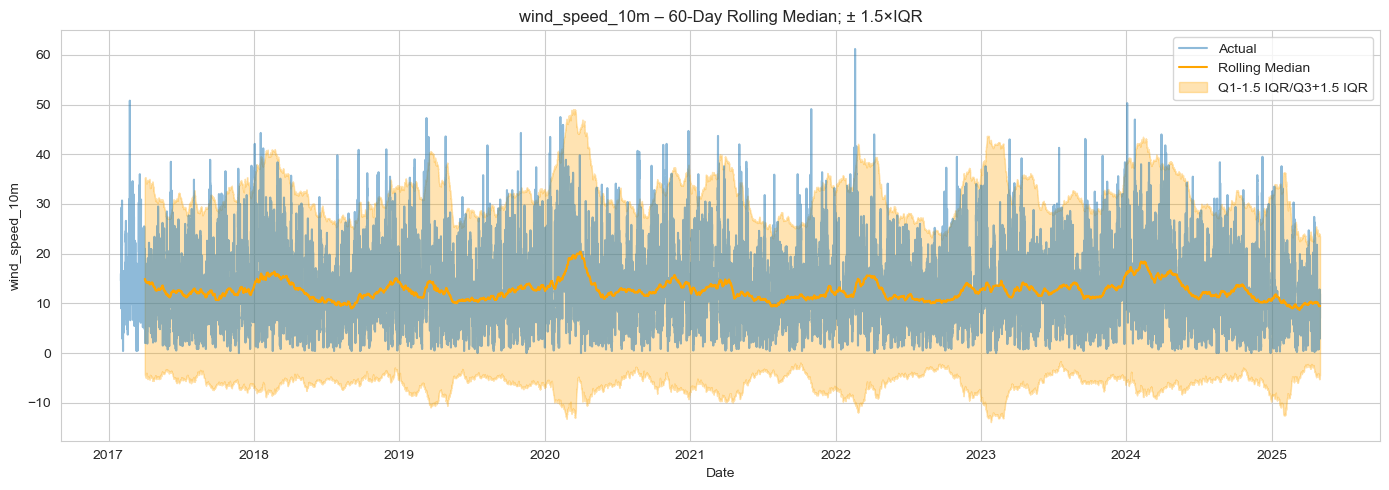

In [13]:
# Plot rolling median ± 1.5 IQR for each feature
for col in features:
    rolling_median = df[col].rolling(window=window).median()
    rolling_q1 = df[col].rolling(window=window).quantile(0.25)
    rolling_q3 = df[col].rolling(window=window).quantile(0.75)
    rolling_iqr = rolling_q3 - rolling_q1
    lower_band = rolling_q1 - 1.5 * rolling_iqr
    upper_band = rolling_q3 + 1.5 * rolling_iqr

    plt.figure(figsize=(14, 5))
    plt.plot(df.index, df[col], label='Actual', alpha=0.5)
    plt.plot(df.index, rolling_median, label='Rolling Median', color='orange')
    plt.fill_between(
        df.index,
        lower_band,
        upper_band,
        color='orange',
        alpha=0.3,
        label='Q1-1.5 IQR/Q3+1.5 IQR'
    )
    plt.title(f'{col} – 60-Day Rolling Median; ± 1.5×IQR')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**INSIGHTS:** Rolling Q1/Q3 ± 1.5×IQR – Key Insights

- Temperature and pressure IQR bands are wider than the std dev bands, offering stricter anomaly thresholding.
- Wind speed shows stricter coverage offering more robust anomaly thresholding. Consider smoothing due to its spiky nature and then using robust normalisation (Tawalkuli, 2024; Wenig, 2022).
- Precipitation is extremely poorly covered; IQR band is too tight for its spiky nature due to most rolling medians and 3rd quartiles resuling in zero (or near-zero) values.
- Consider log-transforming precipitation (e.g. log1p) before using standard rolling stats (mean & std dev) to make rolling z-scores meaningful.

*Note*: These bands help **visualise outlier coverage** (EDA baseline), not to be confused with **input normalisation**.


## Step 9 Precipitation Transformation & Normalisation
**Purpose**: Transform precipitation values to improve rolling stats. <br>
**Method**:
- Log-transform precipitation values using `log1p` and compare with `Yeo-Johnson` power transformation
- Compute rolling stats on transformed data
- Create rolling bands using the rolling stats
- Plot both bands
> Note: tested on 2023 data for better granularity

**Precipitation values for 2023 transformed using 'log1p' and corresponding rolling stats:**

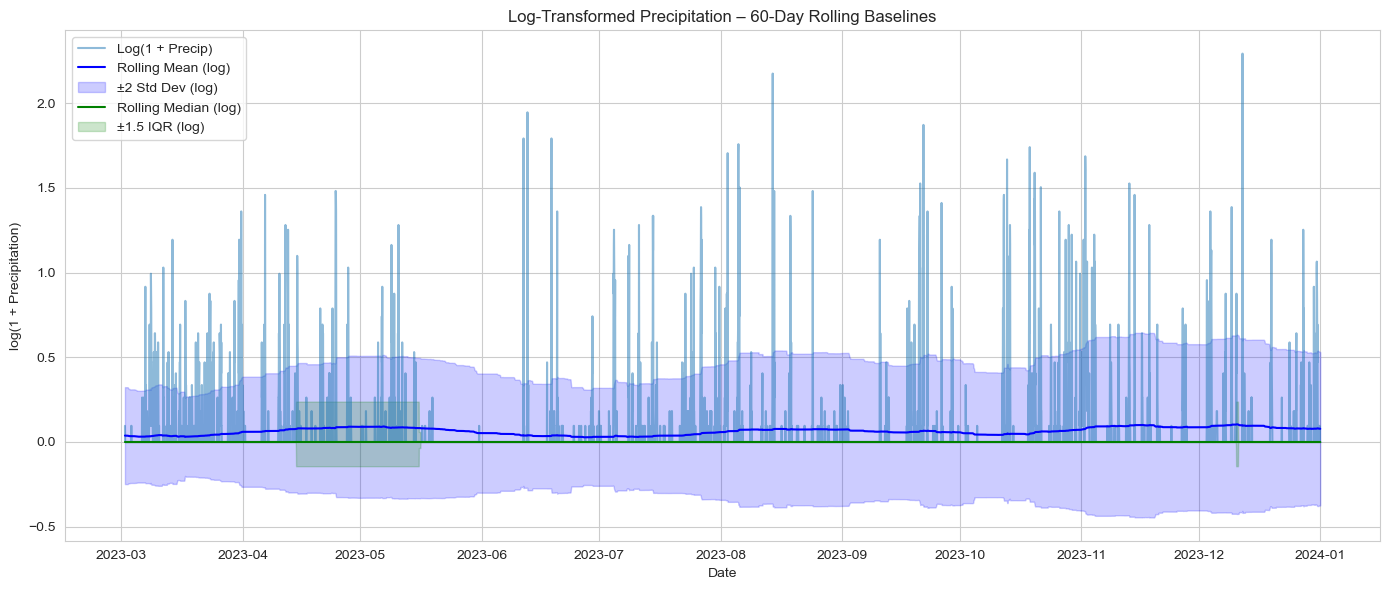

In [14]:
# Preprocess precipitation with log1p transformation
df['precip_log'] = np.log1p(df['precipitation'])
# Separate out year 2023
df_2023 = df[df['year'] == 2023].copy()
# Recompute rolling bands on log-transformed precipitation
rolling_mean_log = df_2023['precip_log'].rolling(window=window).mean()
rolling_std_log = df_2023['precip_log'].rolling(window=window).std()
mean_lower_log = rolling_mean_log - 2 * rolling_std_log
mean_upper_log = rolling_mean_log + 2 * rolling_std_log

rolling_median_log = df_2023['precip_log'].rolling(window=window).median()
q1_log = df_2023['precip_log'].rolling(window=window).quantile(0.25)
q3_log = df_2023['precip_log'].rolling(window=window).quantile(0.75)
iqr_log = q3_log - q1_log
iqr_lower_log = q1_log - 1.5 * iqr_log
iqr_upper_log = q3_log + 1.5 * iqr_log

# Build clean plotting frame
log_plot_df = pd.DataFrame({
    "value": df_2023['precip_log'],
    "mean": rolling_mean_log,
    "mean_lower": mean_lower_log,
    "mean_upper": mean_upper_log,
    "median": rolling_median_log,
    "iqr_lower": iqr_lower_log,
    "iqr_upper": iqr_upper_log
}).dropna()

# Plot both bands
x = log_plot_df.index.to_numpy()
val = log_plot_df["value"].to_numpy(dtype="float64")
mean = log_plot_df["mean"].to_numpy(dtype="float64")
mean_l = log_plot_df["mean_lower"].to_numpy(dtype="float64")
mean_u = log_plot_df["mean_upper"].to_numpy(dtype="float64")
median = log_plot_df["median"].to_numpy(dtype="float64")
iqr_l = log_plot_df["iqr_lower"].to_numpy(dtype="float64")
iqr_u = log_plot_df["iqr_upper"].to_numpy(dtype="float64")

plt.figure(figsize=(14, 6))
plt.plot(x, val, label='Log(1 + Precip)', alpha=0.5)
plt.plot(x, mean, label='Rolling Mean (log)', color='blue')
plt.fill_between(x, mean_l, mean_u, color='blue', alpha=0.2, label='±2 Std Dev (log)')
plt.plot(x, median, label='Rolling Median (log)', color='green')
plt.fill_between(x, iqr_l, iqr_u, color='green', alpha=0.2, label='±1.5 IQR (log)')
plt.title('Log-Transformed Precipitation – 60-Day Rolling Baselines')
plt.xlabel('Date')
plt.ylabel('log(1 + Precipitation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Precipitation values for 2023 transformed using `yeo-johnson` and corresponding rolling stats:**

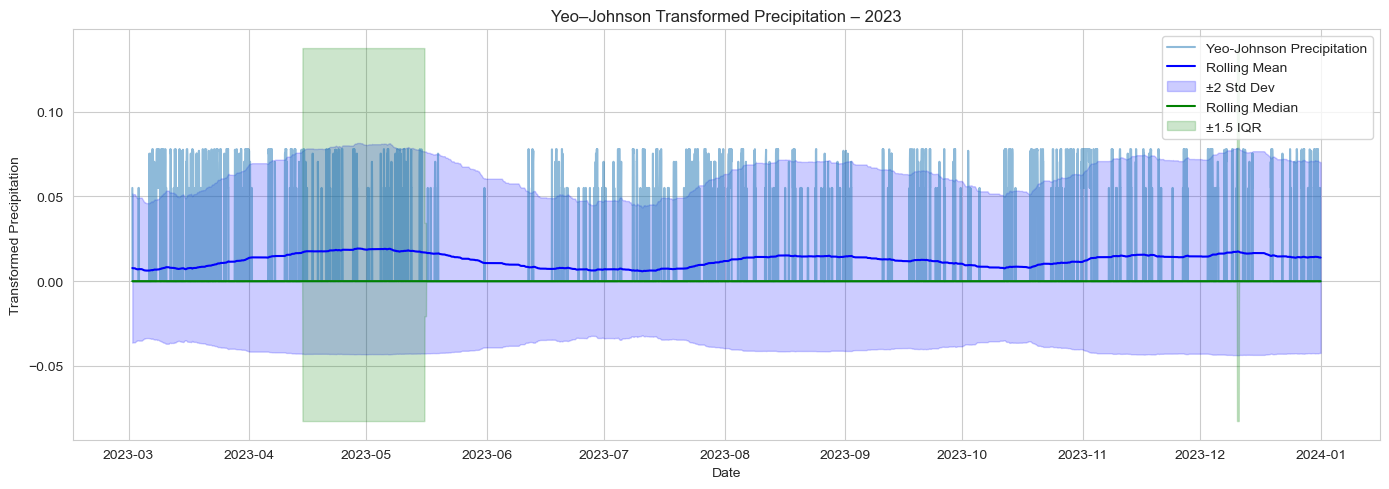

In [15]:
from sklearn.preprocessing import PowerTransformer

# Yeo–Johnson transformation (handles 0s and positives)
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_2023['precip_yeoj'] = pt.fit_transform(df_2023[['precipitation']])

# Compute rolling stats on transformed data
window = 1440
series = df_2023['precip_yeoj']
rolling_mean = series.rolling(window).mean()
rolling_std = series.rolling(window).std()
rolling_q1 = series.rolling(window).quantile(0.25)
rolling_q3 = series.rolling(window).quantile(0.75)
rolling_iqr = rolling_q3 - rolling_q1

# Create bounds
mean_lower = rolling_mean - 2 * rolling_std
mean_upper = rolling_mean + 2 * rolling_std
iqr_lower = rolling_q1 - 1.5 * rolling_iqr
iqr_upper = rolling_q3 + 1.5 * rolling_iqr

# Assemble plotting DataFrame
plot_df = pd.DataFrame({
    'value': series,
    'mean': rolling_mean,
    'mean_lower': mean_lower,
    'mean_upper': mean_upper,
    'median': series.rolling(window).median(),
    'iqr_lower': iqr_lower,
    'iqr_upper': iqr_upper
}).dropna()

# Plot
plt.figure(figsize=(14, 5))
plt.plot(plot_df.index, plot_df['value'], label='Yeo-Johnson Precipitation', alpha=0.5)
plt.plot(plot_df.index, plot_df['mean'], label='Rolling Mean', color='blue')
plt.fill_between(plot_df.index, plot_df['mean_lower'], plot_df['mean_upper'], alpha=0.2, color='blue', label='±2 Std Dev')
plt.plot(plot_df.index, plot_df['median'], label='Rolling Median', color='green')
plt.fill_between(plot_df.index, plot_df['iqr_lower'], plot_df['iqr_upper'], alpha=0.2, color='green', label='±1.5 IQR')
plt.title('Yeo–Johnson Transformed Precipitation – 2023')
plt.xlabel('Date')
plt.ylabel('Transformed Precipitation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**INSIGHTS:** Precipitation – Final Verdict on 1440hr Rolling Stats

Rolling 1440-hour mean and IQR do not work well for precipitation. Even after transformations, the bands are too narrow and miss many normal values. Use a **shorter rolling window (e.g. 12hrs or 24hrs)** for a stronger fit.

Unlike `Yeo-Johnson`, which dampens anomalies, the log transformation (`log1p`) preserves spike visibility and small/mid rainfall variation (Darban, 2024; Tawalkuli, 2024).

**Logged Precipitation Normalisation Comparison: 12h vs 24h Rolling Window:**

**Mean + 2 * St Dev Banding**

In [16]:
# Step 1: Compute rolling upper bounds for 12h and 24h
df["upper_12h"] = df["precip_log"].rolling(12).mean() + 2 * df["precip_log"].rolling(12).std()
df["upper_24h"] = df["precip_log"].rolling(24).mean() + 2 * df["precip_log"].rolling(24).std()

# Step 2: Define rainy hours
rainy_hours = df["precipitation"] > 0

# Step 3: Flag upper-bound anomalies (one-tailed only)
df["is_outlier_12h"] = (df["precip_log"] > df["upper_12h"]) & rainy_hours
df["is_outlier_24h"] = (df["precip_log"] > df["upper_24h"]) & rainy_hours

# Step 4: Calculate detection stats
total_rain_hours = rainy_hours.sum()
spikes_12h = df["is_outlier_12h"].sum()
spikes_24h = df["is_outlier_24h"].sum()

catch_rate_12h = spikes_12h / total_rain_hours
catch_rate_24h = spikes_24h / total_rain_hours

# Step 5: IQRs (for characterising band stability, not for flagging)
iqr_12h = df.loc[rainy_hours, "precip_log"].rolling(12).apply(
    lambda x: pd.Series(x).quantile(0.75) - pd.Series(x).quantile(0.25)
).dropna().mean()

iqr_24h = df.loc[rainy_hours, "precip_log"].rolling(24).apply(
    lambda x: pd.Series(x).quantile(0.75) - pd.Series(x).quantile(0.25)
).dropna().mean()

# Step 6: Output
print(f"Mean and Std Dev Banding Stats across {len(df)} hours")
print(f"Total rainy hours: {total_rain_hours}")
print(f"12h catch rate: {catch_rate_12h:.2%} ({spikes_12h} spikes)")
print(f"24h catch rate: {catch_rate_24h:.2%} ({spikes_24h} spikes)")
print(f"Mean IQR of 12h window (rainy hours): {iqr_12h:.2f}")
print(f"Mean IQR of 24h window (rainy hours): {iqr_24h:.2f}")

Mean and Std Dev Banding Stats across 72264 hours
Total rainy hours: 12359
12h catch rate: 32.16% (3975 spikes)
24h catch rate: 34.56% (4271 spikes)
Mean IQR of 12h window (rainy hours): 0.31
Mean IQR of 24h window (rainy hours): 0.34


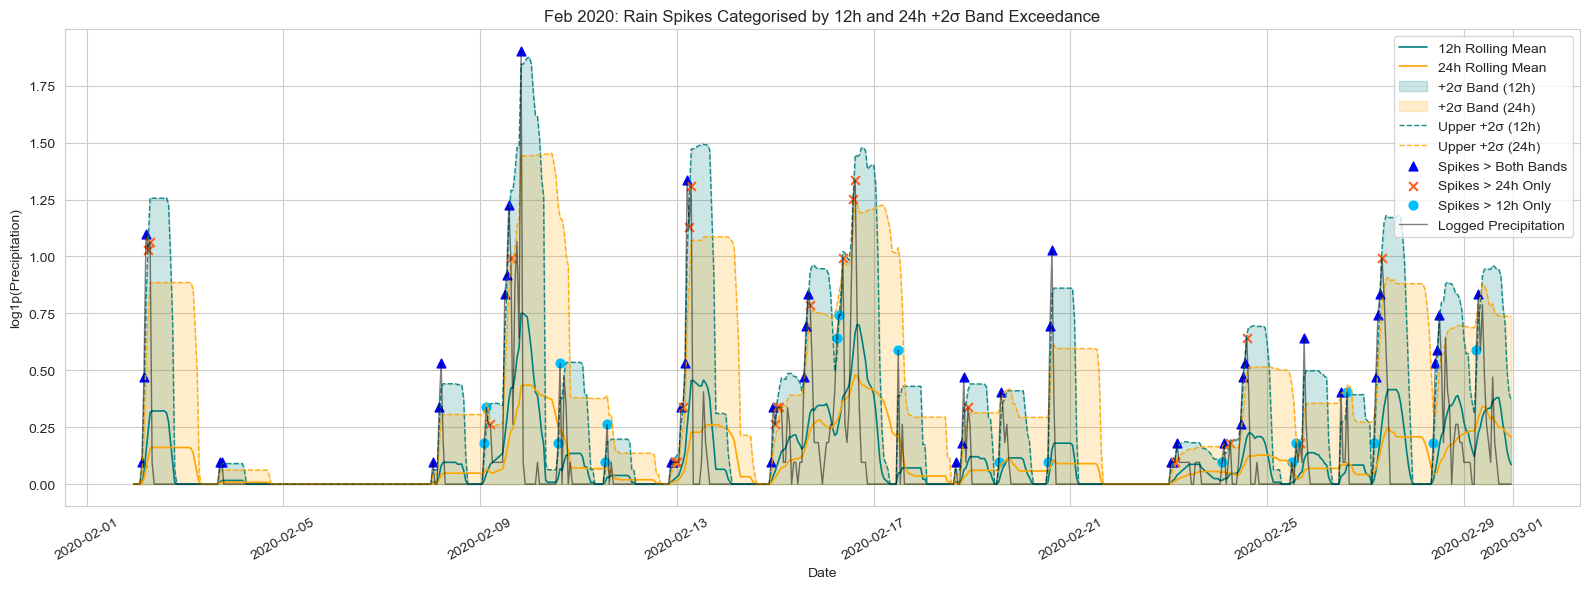

In [17]:
    # Visual Comparison of 12h vs 24h Rolling Bands on log1p(Precipitation) — Feb 2020

# Step 1: Subset to Feb 2020 and compute log1p
df_Feb2020 = df["2020-02-01":"2020-02-29"].copy()

# Step 2: Compute rolling means and bounds
df_Feb2020["mean_12h"] = df_Feb2020["precip_log"].rolling(12).mean()
df_Feb2020["std_12h"] = df_Feb2020["precip_log"].rolling(12).std()
df_Feb2020["upper_12h"] = df_Feb2020["mean_12h"] + 2 * df_Feb2020["std_12h"]

df_Feb2020["mean_24h"] = df_Feb2020["precip_log"].rolling(24).mean()
df_Feb2020["std_24h"] = df_Feb2020["precip_log"].rolling(24).std()
df_Feb2020["upper_24h"] = df_Feb2020["mean_24h"] + 2 * df_Feb2020["std_24h"]

# Step 3: Prepare clean arrays
plot_df = df_Feb2020.dropna(subset=[
    "precip_log", "mean_12h", "mean_24h",
    "upper_12h", "upper_24h", "precipitation"
]).copy()

x = plot_df.index
y = plot_df["precip_log"].astype("float64").values
mean_12h = plot_df["mean_12h"].astype("float64").values
mean_24h = plot_df["mean_24h"].astype("float64").values
upper_12h = plot_df["upper_12h"].astype("float64").values
upper_24h = plot_df["upper_24h"].astype("float64").values
rain_spikes = plot_df["precipitation"].values > 0

# Spike categories
both = (y > upper_12h) & (y > upper_24h) & rain_spikes
only_24h = (y > upper_24h) & ~both & rain_spikes
only_12h = (y > upper_12h) & ~both & rain_spikes

# Plot
plt.figure(figsize=(16, 6))

# Rolling means
plt.plot(x, mean_12h, label="12h Rolling Mean", color="teal", linewidth=1.2)
plt.plot(x, mean_24h, label="24h Rolling Mean", color="orange", linewidth=1.2)

# Fill bands (0 to +2σ)
plt.fill_between(x, 0, upper_12h, color="teal", alpha=0.2, label="+2σ Band (12h)")
plt.fill_between(x, 0, upper_24h, color="orange", alpha=0.2, label="+2σ Band (24h)")

# Dashed upper bound outlines
plt.plot(x, upper_12h, color="teal", linestyle="--", linewidth=1, alpha=0.9, label="Upper +2σ (12h)")
plt.plot(x, upper_24h, color="orange", linestyle="--", linewidth=1, alpha=0.9, label="Upper +2σ (24h)")

# Spike markers by category
plt.scatter(x[both], y[both], color="blue", marker="^", s=40, label="Spikes > Both Bands")
plt.scatter(x[only_24h], y[only_24h], color="#FF5F1F", marker="x", s=40, label="Spikes > 24h Only")
plt.scatter(x[only_12h], y[only_12h], color="#00BFFF", marker="o", s=40, label="Spikes > 12h Only")

# Raw log1p precipitation
plt.plot(x, y, label="Logged Precipitation", color="black", linewidth=1, alpha = 0.5)

# Final layout
plt.title("Feb 2020: Rain Spikes Categorised by 12h and 24h +2σ Band Exceedance")
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.ylabel("log1p(Precipitation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Q3 + 1.5 * IQR Banding**

In [18]:
# Step 1: Compute rolling upper bounds for IQR banding
df["Q1_12h"] = df["precip_log"].rolling(12).quantile(0.25)
df["Q3_12h"] = df["precip_log"].rolling(12).quantile(0.75)
df["upper_IQR_12h"] = df["Q3_12h"] + 1.5 * (df["Q3_12h"] - df["Q1_12h"])

df["Q1_24h"] = df["precip_log"].rolling(24).quantile(0.25)
df["Q3_24h"] = df["precip_log"].rolling(24).quantile(0.75)
df["upper_IQR_24h"] = df["Q3_24h"] + 1.5 * (df["Q3_24h"] - df["Q1_24h"])

# Step 2: Define rainy hours
rainy_hours = df["precipitation"] > 0

# Step 3: Flag upper-bound anomalies (IQR-based)
df["iqr_outlier_12h"] = (df["precip_log"] > df["upper_IQR_12h"]) & rainy_hours
df["iqr_outlier_24h"] = (df["precip_log"] > df["upper_IQR_24h"]) & rainy_hours

# Step 4: Calculate detection stats
total_rain_hours = rainy_hours.sum()
spikes_iqr_12h = df["iqr_outlier_12h"].sum()
spikes_iqr_24h = df["iqr_outlier_24h"].sum()

catch_rate_iqr_12h = spikes_iqr_12h / total_rain_hours
catch_rate_iqr_24h = spikes_iqr_24h / total_rain_hours

# Step 5: Compute average IQRs
iqr_12h = (df.loc[rainy_hours, "Q3_12h"] - df.loc[rainy_hours, "Q1_12h"]).mean()
iqr_24h = (df.loc[rainy_hours, "Q3_24h"] - df.loc[rainy_hours, "Q1_24h"]).mean()

# Step 6: Output using print() formatting to match mean + std dev output

print(f"IQR Banding Stats across {len(df)} hours")
print(f"Total rainy hours: {total_rain_hours}")
print(f"12h catch rate: {catch_rate_iqr_12h:.2%} ({spikes_iqr_12h} spikes)")
print(f"24h catch rate: {catch_rate_iqr_24h:.2%} ({spikes_iqr_24h} spikes)")
print(f"Mean IQR of 12h window (rainy hours): {iqr_12h:.2f}")
print(f"Mean IQR of 24h window (rainy hours): {iqr_24h:.2f}")

IQR Banding Stats across 72264 hours
Total rainy hours: 12359
12h catch rate: 41.60% (5141 spikes)
24h catch rate: 51.90% (6414 spikes)
Mean IQR of 12h window (rainy hours): 0.21
Mean IQR of 24h window (rainy hours): 0.17


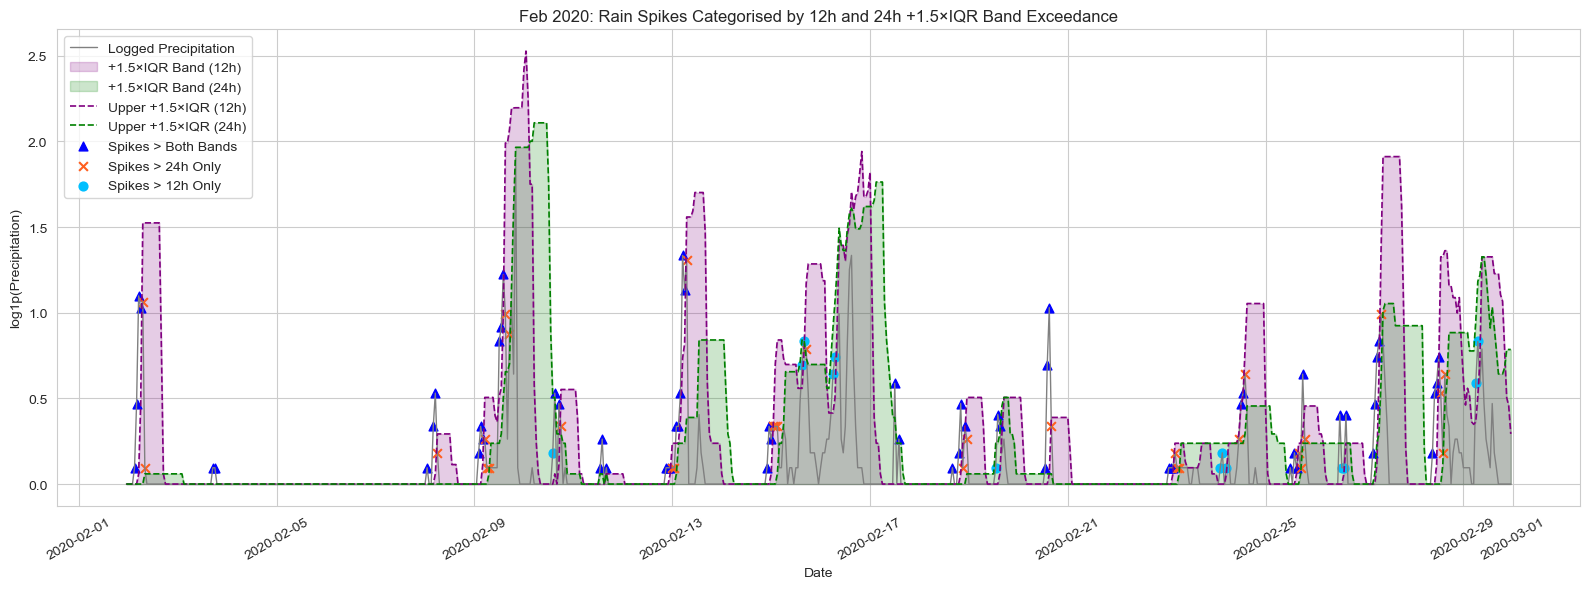

In [19]:
# Compute rolling Q1, Q3, IQR and upper bounds for 12h and 24h
for window in [12, 24]:
    q1_col = f"Q1_{window}h"
    q3_col = f"Q3_{window}h"
    iqr_col = f"IQR_{window}h"
    upper_iqr_col = f"upper_IQR_{window}h"

    df_Feb2020[q1_col] = df_Feb2020["precip_log"].rolling(window).quantile(0.25)
    df_Feb2020[q3_col] = df_Feb2020["precip_log"].rolling(window).quantile(0.75)
    df_Feb2020[iqr_col] = df_Feb2020[q3_col] - df_Feb2020[q1_col]
    df_Feb2020[upper_iqr_col] = df_Feb2020[q3_col] + 1.5 * df_Feb2020[iqr_col]

# Clean and prepare data
plot_df = df_Feb2020.dropna(subset=[
    "precip_log", "Q3_12h", "Q3_24h", "upper_IQR_12h", "upper_IQR_24h", "precipitation"
]).copy()

# Define arrays
x = plot_df.index
y = plot_df["precip_log"].astype("float64").values
upper_iqr_12h = plot_df["upper_IQR_12h"].astype("float64").values
upper_iqr_24h = plot_df["upper_IQR_24h"].astype("float64").values
rain_spikes = plot_df["precipitation"].values > 0

# Spike categories
both = (y > upper_iqr_12h) & (y > upper_iqr_24h) & rain_spikes
only_24h = (y > upper_iqr_24h) & ~both & rain_spikes
only_12h = (y > upper_iqr_12h) & ~both & rain_spikes
only_24h = (y > upper_iqr_24h) & ~both & rain_spikes

# Plot
plt.figure(figsize=(16, 6))

# Plot raw log1p precipitation
plt.plot(x, y, label="Logged Precipitation", color="gray", linewidth=1)

# Fill areas under the upper IQR bands
plt.fill_between(x, 0, upper_iqr_12h, color="purple", alpha=0.2, label="+1.5×IQR Band (12h)")
plt.fill_between(x, 0, upper_iqr_24h, color="green", alpha=0.2, label="+1.5×IQR Band (24h)")

# Outline of the upper bounds
plt.plot(x, upper_iqr_12h, color="purple", linestyle="--", linewidth=1.2, label="Upper +1.5×IQR (12h)")
plt.plot(x, upper_iqr_24h, color="green", linestyle="--", linewidth=1.2, label="Upper +1.5×IQR (24h)")

# Spike markers
plt.scatter(x[both], y[both], color="blue", marker="^", s=40, label="Spikes > Both Bands")
plt.scatter(x[only_24h], y[only_24h], color="#FF5F1F", marker="x", s=40, label="Spikes > 24h Only")
plt.scatter(x[only_12h], y[only_12h], color="#00BFFF", marker="o", s=40, label="Spikes > 12h Only")

# Final layout
plt.title("Feb 2020: Rain Spikes Categorised by 12h and 24h +1.5×IQR Band Exceedance")
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.ylabel("log1p(Precipitation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Precipitation Banding Insights (12h vs 24h)**

We compared **z-score** and **IQR-based** anomaly banding for `log1p(precipitation)` using 12-hour and 24-hour rolling windows across 12,359 rainy hours.

*Quantitative Summary*

| Band Type          | 12h Catch Rate | 24h Catch Rate | Mean Band Width |
|--------------------|----------------|----------------|-----------------|
| Z ±2σ              | 32.2% (3,976)  | 34.6% (4,271)  | ~0.206          |
| Q3 + 1.5×IQR       | 41.6% (5,142)  | 51.9% (6,414)  | ~0.210 / 0.166  |

- **IQR bands flag more spikes**, but are more sensitive and prone to over-flagging in quiet periods.
- **Z-score bands are more stable** and consistent across dry and wet phases.
- The **24-hour band** isolates larger outliers, while the **12-hour band** is quicker to adapt and flags smaller bursts.
- These effects are clearly seen in the **February 2020 plots** (Storm Ciara and Storm Dennis), where the 12h band captured short bursts and the 24h band exposed sharper transitions.

**Recommendation for Isolation Forest**

Use **both 12-hour and 24-hour z-score features** for `log1p(precipitation)`:

```python
df["precip_z_12h"] = ...
df["precip_z_24h"] = ...
```
- Wenig (2022): “Multi-scale z-score features enhance anomaly visibility across regimes”
- Bara (2024): “12h and 24h rolling windows together catch both frontal and convective rain spikes”
- Darban (2024): “Stacking temporal z-scores helps unsupervised models detect more generalisable patterns”